The first code block uses gradCAM without specifying a target (used for explainnig 'dog' vs 'cat' in the documentation for classification). What I think it does is explain where the model pays attention regardless of which KP is being predicted, but there isn't much documentation for it for different use cases than classification.

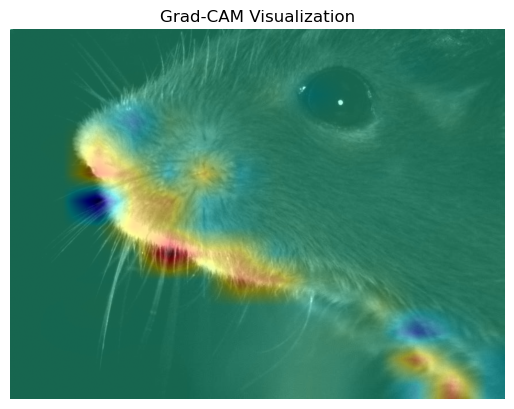

In [2]:
import torch
import timm
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load the Model
num_output_classes = 24  # Same as used during training

model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    in_chans=1,
    num_classes=num_output_classes,
    patch_size=16,
)

model.load_state_dict(torch.load("models/best_model.pt", map_location=device))
model = model.to(device)
model.eval()

# # Define a function for reshaping the feature map
# def reshape_transform(tensor, height=14, width=14):
#     result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
#     result = result.transpose(2, 3).transpose(1, 2)  # Bring channels to the first dimension
#     return result
 

# Define the target layers for Grad-CAM
target_layers = [model.blocks[-1].norm1]  # Targeting the last layer of the transformer blocks

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=vit_reshape_transform)

# Load and preprocess the image
img_path = "/Users/annastuckert/Documents/GitHub/facemap/cam1_G7c1_1_img0703.png"
im = Image.open(img_path).convert("L")  # Ensure the image is grayscale

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to model input size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Apply transformations
x = transform(im)
input_tensor = x.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Generate Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor)

# Show the Grad-CAM visualization
# If the original image needs to be converted to numpy array for visualization
original_image = np.array(im) / 255.0  # Normalize the original image



# Resize the Grad-CAM heatmap to the original image dimensions
heatmap = grayscale_cam[0]  # Get the first (and only) heatmap
heatmap = np.uint8(255 * heatmap)  # Convert to uint8
heatmap_resized = cv2.resize(heatmap, (im.width, im.height))  # Resize to match original image size

# Normalize and apply colormap
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Convert the original image to RGB for visualization
original_image_rgb = np.stack([original_image]*3, axis=-1)  # Convert grayscale to RGB

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(original_image_rgb, 0.6, heatmap_colored / 255.0, 0.4, 0)

# Display the result
plt.imshow(superimposed_img)
plt.axis('off')
plt.title('Grad-CAM Visualization')
plt.show()


In [57]:
print(grayscale_cam)

[[[0.57053125 0.57053125 0.57053125 ... 0.569124   0.569124   0.569124  ]
  [0.57053125 0.57053125 0.57053125 ... 0.569124   0.569124   0.569124  ]
  [0.57053125 0.57053125 0.57053125 ... 0.569124   0.569124   0.569124  ]
  ...
  [0.57087666 0.57087666 0.57087666 ... 0.631095   0.631095   0.631095  ]
  [0.57087666 0.57087666 0.57087666 ... 0.631095   0.631095   0.631095  ]
  [0.57087666 0.57087666 0.57087666 ... 0.631095   0.631095   0.631095  ]]]


In [4]:
#model.blocks
model.blocks[-1] #I believe this takes the last attention layer
#model.blocks[-1].norm1 #this is the layer used for gradCAM

Block(
  (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

The following code tries to implement the code using specific targets

In [62]:
input_tensor = x.unsqueeze(0).to(device) 

print(input_tensor)

tensor([[[[-0.6706, -0.9216, -1.0000,  ..., -0.9529, -0.9686, -0.9608],
          [-0.9608, -0.9686, -1.0000,  ..., -0.9451, -0.9608, -0.9451],
          [-0.9765, -0.9765, -1.0000,  ..., -0.9451, -0.9608, -0.9686],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.6784, -0.6706, -0.6706],
          [-1.0000, -1.0000, -1.0000,  ..., -0.6471, -0.6627, -0.6549],
          [-1.0000, -1.0000, -1.0000,  ..., -0.6471, -0.6549, -0.6627]]]])


In [63]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(20)]

# Construct the CAM object once, and then re-use it on many images.
cam = GradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)


  # # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  # grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # # In this example grayscale_cam has only one image in the batch:
  # grayscale_cam = grayscale_cam[0, :]
  # visualization = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)
  # # You can also get the model outputs without having to redo inference
  # model_outputs = cam.outputs